# Resale HDB Price Analytics


[Overall](#Overall)

[DBSS](#DBSS)

In [1]:
import os, sys
import re, json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from glob import glob

import matplotlib
matplotlib.style.use('ggplot')

%matplotlib inline
pd.set_option('display.max_columns',300)
pd.set_option('display.max_rows',2000)

from utils import *

In [2]:
latest_file = [x for x in glob('./output_latest/*.xlsx') if '~' not in x][-1]
latest_file

'./output_latest\\HDB_resale_prices_2021-01-18.xlsx'

In [3]:
hdb = pd.read_excel(latest_file)

In [4]:
hdb.head()

,Town Code,Town,Block,Street,Storey,Floor Area/Flat Model,Floor Area,Flat Model,Flat Type,Lease Commencement Date,Remaining Lease,Price,Resale Registration Date,Resale Registration Month,Resale Registration Year
0,AMK,Ang Mo Kio,170,Ang Mo Kio Ave 4,07 to 09,45.00Improved,45.0,Improved,2-Room,1986,64 years 1 month,"$225,000.00",Jan 2021,Jan,2021
1,AMK,Ang Mo Kio,314,Ang Mo Kio Ave 3,10 to 12,44.00Improved,44.0,Improved,2-Room,1978,56 years 2 months,"$214,000.00",Dec 2020,Dec,2020
2,AMK,Ang Mo Kio,323,Ang Mo Kio Ave 3,04 to 06,44.00Improved,44.0,Improved,2-Room,1977,55 years 6 months,"$218,000.00",Dec 2020,Dec,2020
3,AMK,Ang Mo Kio,314,Ang Mo Kio Ave 3,10 to 12,44.00Improved,44.0,Improved,2-Room,1978,56 years 4 months,"$220,000.00",Oct 2020,Oct,2020
4,AMK,Ang Mo Kio,508,Ang Mo Kio Ave 8,04 to 06,44.00Improved,44.0,Improved,2-Room,1980,58 years 9 months,"$200,000.00",Sep 2020,Sep,2020


In [5]:
hdb = preprocessHDBdf(hdb)

In [6]:
hdb.shape

(24641, 24)

In [7]:
hdb.columns

Index(['Town Code', 'Town', 'Block', 'Street', 'Storey',
       'Floor Area/Flat Model', 'Floor Area', 'Flat Model', 'Flat Type',
       'Lease Commencement Date', 'Remaining Lease', 'Price',
       'Resale Registration Date', 'Resale Registration Month',
       'Resale Registration Year', 'Remaining Lease (Year)',
       'Remaining Lease (Month)', 'Remaining Lease in Months', 'Sqm', 'Sqft',
       'Price per Sqm', 'Price per Sqft',
       'Price per Sqft per Remaining Lease year', 'Storey Range + Flat Type'],
      dtype='object')

<a id='Overall'>Overall</a>

In [8]:
hdb['Resale Registration Year'].unique()

array([2020, 2021], dtype=int64)

In [9]:
n_months = len(hdb['Resale Registration Month'].unique())

## Resale Volume

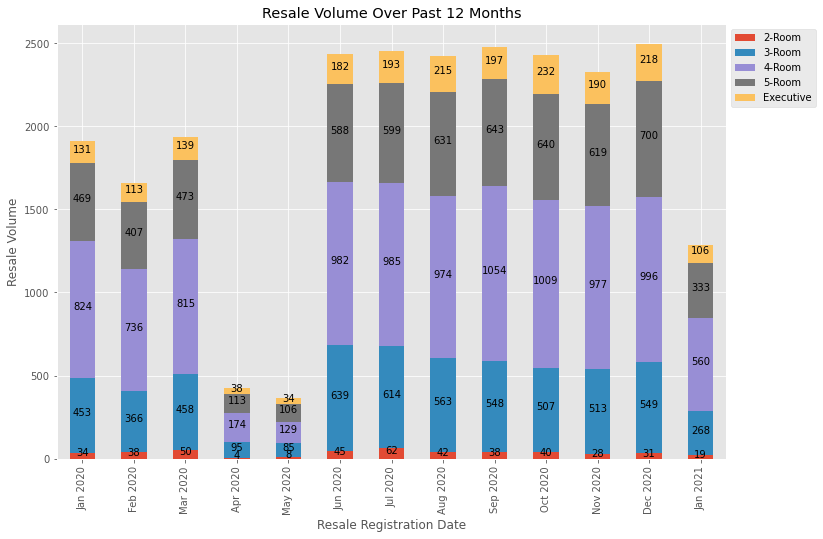

In [10]:
hdb_vol = hdb[hdb['Flat Type'].isin(['2-Room','3-Room','4-Room','5-Room','Executive'])].\
groupby(['Resale Registration Date','Flat Type']).agg({'Town':'count'}).unstack('Flat Type').fillna(0).reset_index()
hdb_vol.columns = ['Resale Registration Date','2-Room','3-Room','4-Room','5-Room','Executive']
hdb_vol['Resale Registration Date'] =  pd.to_datetime(hdb_vol['Resale Registration Date'], format='%b %Y')
hdb_vol = hdb_vol.sort_values(by=['Resale Registration Date'], ascending=True)
hdb_vol['Resale Registration Date'] = hdb_vol['Resale Registration Date'].apply(lambda x: datetime.strftime(x, '%b %Y'))
hdb_vol.set_index(['Resale Registration Date'], inplace=True)
ax = hdb_vol.plot(kind='bar', stacked=True, figsize=(12,8), title=f'Resale Volume Over Past {n_months} Months')
ax.legend(bbox_to_anchor=(1, 1))
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0 and height < np.inf:
        ax.annotate(int(round(height)),\
                    (x+width/2, y+height/2),\
                    ha='center', va='center', xytext=(0, 3), textcoords='offset points')
ax.set_ylabel('Resale Volume')
plt.show()

## Total Resale Volume by Town

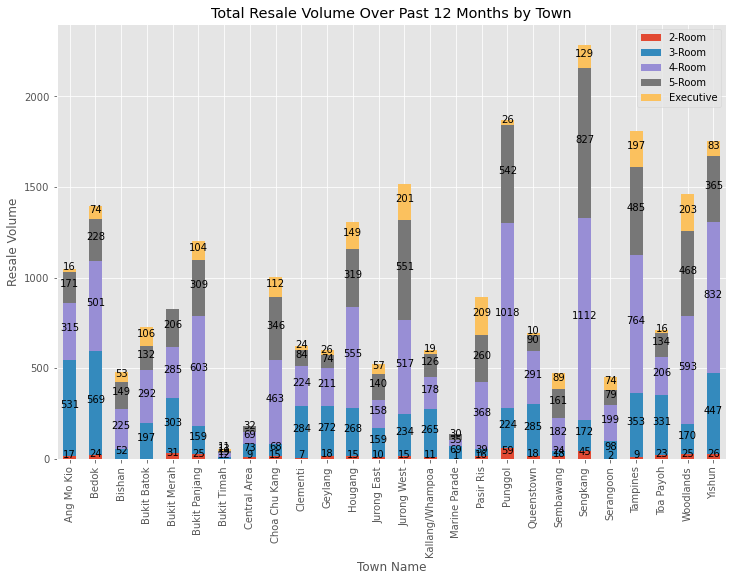

In [11]:
hdb_vol = hdb[hdb['Flat Type'].isin(['2-Room','3-Room','4-Room','5-Room','Executive'])].\
groupby(['Town','Flat Type']).agg({'Town':'count'}).unstack('Flat Type').fillna(0).reset_index()

hdb_vol.columns = ['Town Name','2-Room','3-Room','4-Room','5-Room','Executive']
hdb_vol

ax = hdb_vol.plot(kind='bar', stacked=True, figsize=(12,8), x='Town Name',\
                  title=f'Total Resale Volume Over Past {n_months} Months by Town')
ax.legend(bbox_to_anchor=(1, 1))
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0 and height < np.inf:
        ax.annotate(int(round(height)),\
                    (x+width/2, y+height/2),\
                    ha='center', va='center', xytext=(0, 3), textcoords='offset points')
ax.set_ylabel('Resale Volume')
plt.show()

## Price Distribution

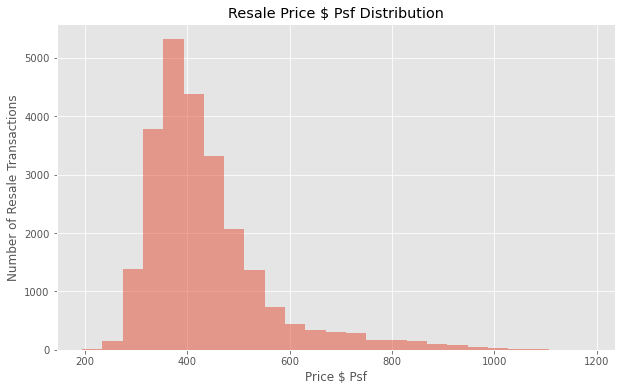

In [12]:
ax = hdb['Price per Sqft'].plot.hist(bins=25, alpha=0.5, figsize=(10,6), title='Resale Price $ Psf Distribution')
ax.set_xlabel('Price $ Psf')
ax.set_ylabel('Number of Resale Transactions')
plt.show()

(0.0, 24641.0)

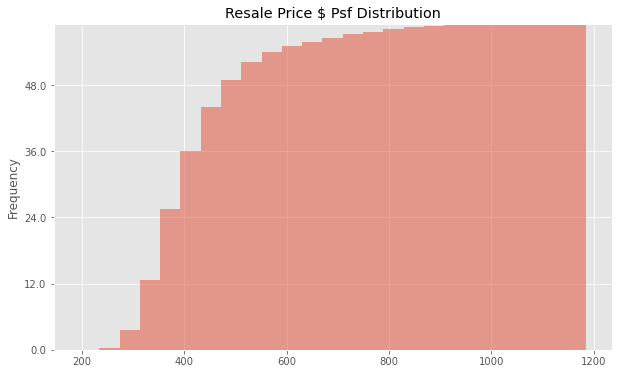

In [13]:
ax1 = hdb['Price per Sqft'].plot.hist(bins=25, alpha=0.5, figsize=(10,6), title='Resale Price $ Psf Distribution', cumulative = True)
ax1.set_yticklabels(np.arange(0,(hdb.shape[0]+1)/hdb.shape[0]*100, round(1/8*100)))
ax1.set_ylim(0,hdb.shape[0])

## Top 5 Most Expensive Resale HDBs for 4-Room and larger HDBs

In [14]:
hdb['Price rank room type'] = hdb.groupby('Flat Type')['Price'].rank(ascending=False)

hdb[(hdb['Price rank room type']<=5)&(hdb['Flat Type'].isin(['4-Room','5-Room','Executive','Multi-Generation']))].\
sort_values(['Flat Type','Town'])

,Town Code,Town,Block,Street,Storey,Floor Area/Flat Model,Floor Area,Flat Model,Flat Type,Lease Commencement Date,Remaining Lease,Price,Resale Registration Date,Resale Registration Month,Resale Registration Year,Remaining Lease (Year),Remaining Lease (Month),Remaining Lease in Months,Sqm,Sqft,Price per Sqm,Price per Sqft,Price per Sqft per Remaining Lease year,Storey Range + Flat Type,Price rank room type
4161,BM,Bukit Merah,43,Moh Guan Ter,04 to 06,131.00Adjoined Flat,131.0,Adjoined,4-Room,1973,51 years 5 months,1088000.0,Aug 2020,Aug,2020,51,0,612,131.0,1410.084,8305.343511,771.585239,15.129122,04 to 06 4-Room,3.0
5864,CT,Central Area,1D,Cantonment Rd,49 to 51,94.00Type S1,94.0,Type,4-Room,2011,89 years 6 months,1085000.0,Jul 2020,Jul,2020,89,0,1068,94.0,1011.816,11542.553191,1072.329356,12.048644,49 to 51 4-Room,4.0
5873,CT,Central Area,1B,Cantonment Rd,40 to 42,93.00Type S1,93.0,Type,4-Room,2011,89 years 9 months,1186888.0,Jun 2020,Jun,2020,89,0,1068,93.0,1001.052,12762.236559,1185.640706,13.321806,40 to 42 4-Room,1.0
5845,CT,Central Area,1G,Cantonment Rd,43 to 45,93.00Type S1,93.0,Type,4-Room,2011,89 years 4 months,1070000.0,Oct 2020,Oct,2020,89,0,1068,93.0,1001.052,11505.376344,1068.875543,12.009838,43 to 45 4-Room,5.0
5851,CT,Central Area,1C,Cantonment Rd,37 to 39,95.00Type S1,95.0,Type,4-Room,2011,89 years 4 months,1100000.0,Sep 2020,Sep,2020,89,0,1068,95.0,1022.580,11578.947368,1075.710458,12.086634,37 to 39 4-Room,2.0
2747,BH,Bishan,273B,Bishan St 24,25 to 27,120.00Dbss,120.0,Dbss,5-Room,2011,89 years 9 months,1218888.0,Dec 2020,Dec,2020,89,0,1068,120.0,1291.680,10157.400000,943.645485,10.602758,25 to 27 5-Room,4.0
2727,BH,Bishan,273A,Bishan St 24,25 to 27,120.00Dbss,120.0,Dbss,5-Room,2011,89 years 8 months,1210000.0,Jan 2021,Jan,2021,89,0,1068,120.0,1291.680,10083.333333,936.764524,10.525444,25 to 27 5-Room,5.0
5924,CT,Central Area,1B,Cantonment Rd,40 to 42,107.00Type S2,107.0,Type,5-Room,2011,89 years 11 months,1232000.0,Mar 2020,Mar,2020,89,0,1068,107.0,1151.748,11514.018692,1069.678437,12.018859,40 to 42 5-Room,3.0
5902,CT,Central Area,1A,Cantonment Rd,49 to 51,105.00Type S2,105.0,Type,5-Room,2011,89 years 3 months,1248000.0,Nov 2020,Nov,2020,89,0,1068,105.0,1130.220,11885.714286,1104.209800,12.406852,49 to 51 5-Room,2.0
5914,CT,Central Area,1B,Cantonment Rd,43 to 45,107.00Type S2,107.0,Type,5-Room,2011,89 years 4 months,1258000.0,Sep 2020,Sep,2020,89,0,1068,107.0,1151.748,11757.009346,1092.252819,12.272504,43 to 45 5-Room,1.0


## Top 5 Least Expensive Resale HDBs for 4-Room and larger HDBs

In [15]:
hdb['Price rank room type (descending)'] = hdb.groupby('Flat Type')['Price'].rank(ascending=True)
hdb[(hdb['Price rank room type (descending)']<=5)&(hdb['Flat Type'].isin(['4-Room','5-Room','Executive','Multi-Generation']))].\
sort_values(['Flat Type','Town'])

,Town Code,Town,Block,Street,Storey,Floor Area/Flat Model,Floor Area,Flat Model,Flat Type,Lease Commencement Date,Remaining Lease,Price,Resale Registration Date,Resale Registration Month,Resale Registration Year,Remaining Lease (Year),Remaining Lease (Month),Remaining Lease in Months,Sqm,Sqft,Price per Sqm,Price per Sqft,Price per Sqft per Remaining Lease year,Storey Range + Flat Type,Price rank room type,Price rank room type (descending)
22028,WL,Woodlands,27,Marsiling Dr,01 to 03,91.00New Generation,91.0,New,4-Room,1977,56 years 7 months,240000.0,Apr 2020,Apr,2020,56,0,672,91.0,979.524,2637.362637,245.016967,4.375303,01 to 03 4-Room,10212.0,4.0
22151,WL,Woodlands,202,Marsiling Dr,10 to 12,96.00New Generation,96.0,New,4-Room,1981,60 years 5 months,238000.0,Jan 2020,Jan,2020,60,0,720,96.0,1033.344,2479.166667,230.320203,3.838670,10 to 12 4-Room,10213.5,2.5
22045,WL,Woodlands,8,Marsiling Dr,01 to 03,90.00Improved,90.0,Improved,4-Room,1976,54 years 10 months,218000.0,Mar 2020,Mar,2020,54,0,648,90.0,968.760,2422.222222,225.029935,4.167221,01 to 03 4-Room,10215.0,1.0
22044,WL,Woodlands,7,Marsiling Dr,07 to 09,90.00Improved,90.0,Improved,4-Room,1976,54 years 10 months,238000.0,Mar 2020,Mar,2020,54,0,648,90.0,968.760,2644.444444,245.674883,4.549535,07 to 09 4-Room,10213.5,2.5
23955,YS,Yishun,390,Yishun Ave 6,04 to 06,84.00Simplified,84.0,Simplified,4-Room,1988,67 years 6 months,247000.0,Mar 2020,Mar,2020,67,0,804,84.0,904.176,2940.476190,273.176904,4.077267,04 to 06 4-Room,10211.0,5.0
9885,JE,Jurong East,403,Pandan Gdns,07 to 09,114.00Standard,114.0,Standard,5-Room,1979,58 years,300000.0,Jun 2020,Jun,2020,58,0,696,114.0,1227.096,2631.578947,244.479650,4.215166,07 to 09 5-Room,6318.0,4.0
22558,WL,Woodlands,9,Marsiling Dr,04 to 06,120.00Standard,120.0,Standard,5-Room,1976,54 years 10 months,285000.0,Apr 2020,Apr,2020,54,0,648,120.0,1291.680,2375.000000,220.642884,4.085979,04 to 06 5-Room,6320.0,2.0
22559,WL,Woodlands,35,Marsiling Dr,13 to 15,118.00Standard,118.0,Standard,5-Room,1977,56 years 6 months,280000.0,Apr 2020,Apr,2020,56,0,672,118.0,1270.152,2372.881356,220.446057,3.936537,13 to 15 5-Room,6321.0,1.0
22639,WL,Woodlands,10,Marsiling Dr,01 to 03,123.00Standard,123.0,Standard,5-Room,1976,55 years 2 months,290000.0,Jan 2020,Jan,2020,55,0,660,123.0,1323.972,2357.723577,219.037865,3.982507,01 to 03 5-Room,6319.0,3.0
22276,WL,Woodlands,35,Marsiling Dr,04 to 06,115.00Standard,115.0,Standard,5-Room,1977,55 years 11 months,307500.0,Nov 2020,Nov,2020,55,0,660,115.0,1237.860,2673.913043,248.412583,4.516592,04 to 06 5-Room,6317.0,5.0


## Top 5 Most Expensive Resale HDBs by PSF by Room Type

In [16]:
hdb['Price per Sqft Rank'] = hdb.groupby('Flat Type')['Price'].rank(ascending=False)

hdb[(hdb['Price per Sqft Rank']<=5)&(hdb['Flat Type'].isin(['4-Room','5-Room','Executive','Multi-Generation']))].\
sort_values(['Flat Type','Town'])

,Town Code,Town,Block,Street,Storey,Floor Area/Flat Model,Floor Area,Flat Model,Flat Type,Lease Commencement Date,Remaining Lease,Price,Resale Registration Date,Resale Registration Month,Resale Registration Year,Remaining Lease (Year),Remaining Lease (Month),Remaining Lease in Months,Sqm,Sqft,Price per Sqm,Price per Sqft,Price per Sqft per Remaining Lease year,Storey Range + Flat Type,Price rank room type,Price rank room type (descending),Price per Sqft Rank
4161,BM,Bukit Merah,43,Moh Guan Ter,04 to 06,131.00Adjoined Flat,131.0,Adjoined,4-Room,1973,51 years 5 months,1088000.0,Aug 2020,Aug,2020,51,0,612,131.0,1410.084,8305.343511,771.585239,15.129122,04 to 06 4-Room,3.0,10213.0,3.0
5864,CT,Central Area,1D,Cantonment Rd,49 to 51,94.00Type S1,94.0,Type,4-Room,2011,89 years 6 months,1085000.0,Jul 2020,Jul,2020,89,0,1068,94.0,1011.816,11542.553191,1072.329356,12.048644,49 to 51 4-Room,4.0,10212.0,4.0
5873,CT,Central Area,1B,Cantonment Rd,40 to 42,93.00Type S1,93.0,Type,4-Room,2011,89 years 9 months,1186888.0,Jun 2020,Jun,2020,89,0,1068,93.0,1001.052,12762.236559,1185.640706,13.321806,40 to 42 4-Room,1.0,10215.0,1.0
5845,CT,Central Area,1G,Cantonment Rd,43 to 45,93.00Type S1,93.0,Type,4-Room,2011,89 years 4 months,1070000.0,Oct 2020,Oct,2020,89,0,1068,93.0,1001.052,11505.376344,1068.875543,12.009838,43 to 45 4-Room,5.0,10211.0,5.0
5851,CT,Central Area,1C,Cantonment Rd,37 to 39,95.00Type S1,95.0,Type,4-Room,2011,89 years 4 months,1100000.0,Sep 2020,Sep,2020,89,0,1068,95.0,1022.580,11578.947368,1075.710458,12.086634,37 to 39 4-Room,2.0,10214.0,2.0
2747,BH,Bishan,273B,Bishan St 24,25 to 27,120.00Dbss,120.0,Dbss,5-Room,2011,89 years 9 months,1218888.0,Dec 2020,Dec,2020,89,0,1068,120.0,1291.680,10157.400000,943.645485,10.602758,25 to 27 5-Room,4.0,6318.0,4.0
2727,BH,Bishan,273A,Bishan St 24,25 to 27,120.00Dbss,120.0,Dbss,5-Room,2011,89 years 8 months,1210000.0,Jan 2021,Jan,2021,89,0,1068,120.0,1291.680,10083.333333,936.764524,10.525444,25 to 27 5-Room,5.0,6317.0,5.0
5924,CT,Central Area,1B,Cantonment Rd,40 to 42,107.00Type S2,107.0,Type,5-Room,2011,89 years 11 months,1232000.0,Mar 2020,Mar,2020,89,0,1068,107.0,1151.748,11514.018692,1069.678437,12.018859,40 to 42 5-Room,3.0,6319.0,3.0
5902,CT,Central Area,1A,Cantonment Rd,49 to 51,105.00Type S2,105.0,Type,5-Room,2011,89 years 3 months,1248000.0,Nov 2020,Nov,2020,89,0,1068,105.0,1130.220,11885.714286,1104.209800,12.406852,49 to 51 5-Room,2.0,6320.0,2.0
5914,CT,Central Area,1B,Cantonment Rd,43 to 45,107.00Type S2,107.0,Type,5-Room,2011,89 years 4 months,1258000.0,Sep 2020,Sep,2020,89,0,1068,107.0,1151.748,11757.009346,1092.252819,12.272504,43 to 45 5-Room,1.0,6321.0,1.0


## Top 5 Least Expensive Resale HDBs by PSF by Room Type

In [17]:
hdb['Price per Sqft Rank (Descending)'] = hdb.groupby('Flat Type')['Price'].rank(ascending=True)

hdb[(hdb['Price per Sqft Rank (Descending)']<=5)&(hdb['Flat Type'].isin(['4-Room','5-Room','Executive','Multi-Generation']))].\
sort_values(['Flat Type','Town'])

,Town Code,Town,Block,Street,Storey,Floor Area/Flat Model,Floor Area,Flat Model,Flat Type,Lease Commencement Date,Remaining Lease,Price,Resale Registration Date,Resale Registration Month,Resale Registration Year,Remaining Lease (Year),Remaining Lease (Month),Remaining Lease in Months,Sqm,Sqft,Price per Sqm,Price per Sqft,Price per Sqft per Remaining Lease year,Storey Range + Flat Type,Price rank room type,Price rank room type (descending),Price per Sqft Rank,Price per Sqft Rank (Descending)
22028,WL,Woodlands,27,Marsiling Dr,01 to 03,91.00New Generation,91.0,New,4-Room,1977,56 years 7 months,240000.0,Apr 2020,Apr,2020,56,0,672,91.0,979.524,2637.362637,245.016967,4.375303,01 to 03 4-Room,10212.0,4.0,10212.0,4.0
22151,WL,Woodlands,202,Marsiling Dr,10 to 12,96.00New Generation,96.0,New,4-Room,1981,60 years 5 months,238000.0,Jan 2020,Jan,2020,60,0,720,96.0,1033.344,2479.166667,230.320203,3.838670,10 to 12 4-Room,10213.5,2.5,10213.5,2.5
22045,WL,Woodlands,8,Marsiling Dr,01 to 03,90.00Improved,90.0,Improved,4-Room,1976,54 years 10 months,218000.0,Mar 2020,Mar,2020,54,0,648,90.0,968.760,2422.222222,225.029935,4.167221,01 to 03 4-Room,10215.0,1.0,10215.0,1.0
22044,WL,Woodlands,7,Marsiling Dr,07 to 09,90.00Improved,90.0,Improved,4-Room,1976,54 years 10 months,238000.0,Mar 2020,Mar,2020,54,0,648,90.0,968.760,2644.444444,245.674883,4.549535,07 to 09 4-Room,10213.5,2.5,10213.5,2.5
23955,YS,Yishun,390,Yishun Ave 6,04 to 06,84.00Simplified,84.0,Simplified,4-Room,1988,67 years 6 months,247000.0,Mar 2020,Mar,2020,67,0,804,84.0,904.176,2940.476190,273.176904,4.077267,04 to 06 4-Room,10211.0,5.0,10211.0,5.0
9885,JE,Jurong East,403,Pandan Gdns,07 to 09,114.00Standard,114.0,Standard,5-Room,1979,58 years,300000.0,Jun 2020,Jun,2020,58,0,696,114.0,1227.096,2631.578947,244.479650,4.215166,07 to 09 5-Room,6318.0,4.0,6318.0,4.0
22558,WL,Woodlands,9,Marsiling Dr,04 to 06,120.00Standard,120.0,Standard,5-Room,1976,54 years 10 months,285000.0,Apr 2020,Apr,2020,54,0,648,120.0,1291.680,2375.000000,220.642884,4.085979,04 to 06 5-Room,6320.0,2.0,6320.0,2.0
22559,WL,Woodlands,35,Marsiling Dr,13 to 15,118.00Standard,118.0,Standard,5-Room,1977,56 years 6 months,280000.0,Apr 2020,Apr,2020,56,0,672,118.0,1270.152,2372.881356,220.446057,3.936537,13 to 15 5-Room,6321.0,1.0,6321.0,1.0
22639,WL,Woodlands,10,Marsiling Dr,01 to 03,123.00Standard,123.0,Standard,5-Room,1976,55 years 2 months,290000.0,Jan 2020,Jan,2020,55,0,660,123.0,1323.972,2357.723577,219.037865,3.982507,01 to 03 5-Room,6319.0,3.0,6319.0,3.0
22276,WL,Woodlands,35,Marsiling Dr,04 to 06,115.00Standard,115.0,Standard,5-Room,1977,55 years 11 months,307500.0,Nov 2020,Nov,2020,55,0,660,115.0,1237.860,2673.913043,248.412583,4.516592,04 to 06 5-Room,6317.0,5.0,6317.0,5.0


## HDB Median Prices and Volume

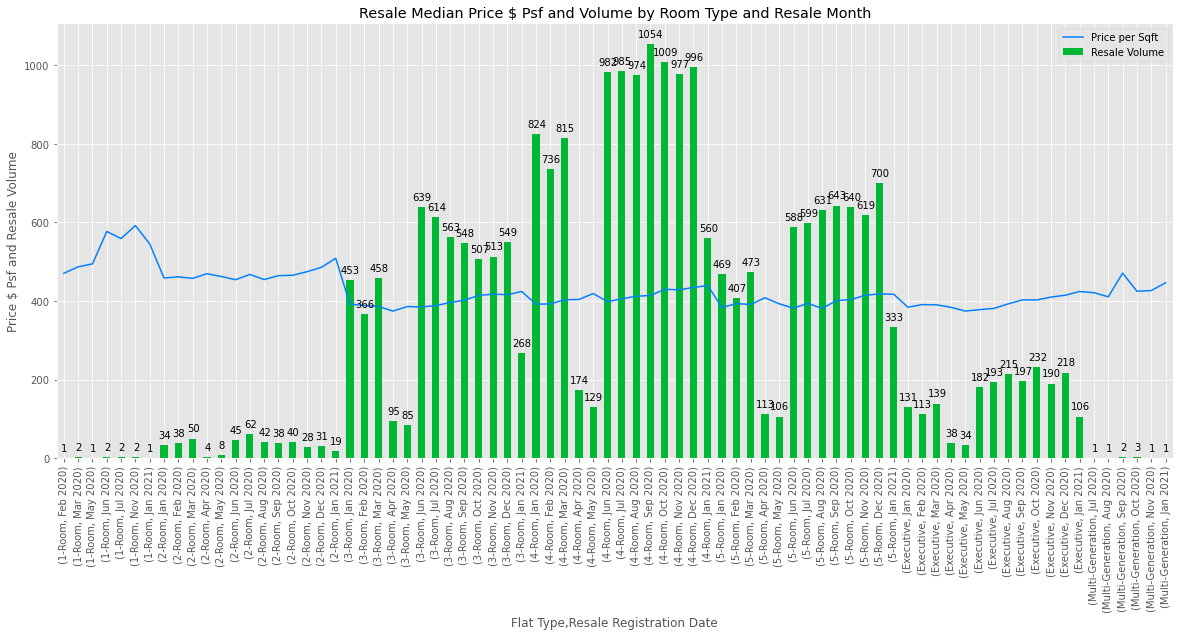

In [18]:
hdb_median_prices_bytime = hdb.groupby(['Flat Type','Resale Registration Date']).agg({'Price per Sqft':'median'}).reset_index()
hdb_median_prices_bytime['Resale Registration Date'] =  pd.to_datetime(hdb_median_prices_bytime['Resale Registration Date'], format='%b %Y')
hdb_median_prices_bytime = hdb_median_prices_bytime.sort_values(by=['Flat Type','Resale Registration Date'], ascending=True)
hdb_median_prices_bytime['Resale Registration Date'] = hdb_median_prices_bytime['Resale Registration Date'].apply(lambda x: datetime.strftime(x, '%b %Y'))
hdb_median_prices_bytime.set_index(['Flat Type','Resale Registration Date'], inplace=True)

hdb_vol_bytime = hdb.groupby(['Flat Type','Resale Registration Date']).agg({'Town':'count'}).reset_index()
hdb_vol_bytime.columns = ['Flat Type','Resale Registration Date','Resale Volume']
hdb_vol_bytime['Resale Registration Date'] =  pd.to_datetime(hdb_vol_bytime['Resale Registration Date'], format='%b %Y')
hdb_vol_bytime = hdb_vol_bytime.sort_values(by=['Flat Type','Resale Registration Date'], ascending=True)
hdb_vol_bytime['Resale Registration Date'] = hdb_vol_bytime['Resale Registration Date'].apply(lambda x: datetime.strftime(x, '%b %Y'))
hdb_vol_bytime.set_index(['Flat Type','Resale Registration Date'], inplace=True)


ax = hdb_median_prices_bytime.plot(kind='line', figsize=(20,8), color = '#0080FF')
ax1 = hdb_vol_bytime.plot(kind='bar', figsize=(20,8), color = '#00b834', ax = ax)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0 and height < np.inf:
        ax.annotate(int(round(height)),\
                    (x+width, y+height),\
                    ha='center', va='center', xytext=(-3, 10), textcoords='offset points')
ax.set_title('Resale Median Price $ Psf and Volume by Room Type and Resale Month')
ax.set_ylabel('Price $ Psf and Resale Volume')
plt.show()

## Price (Median) per Sqft by Town and Room Type

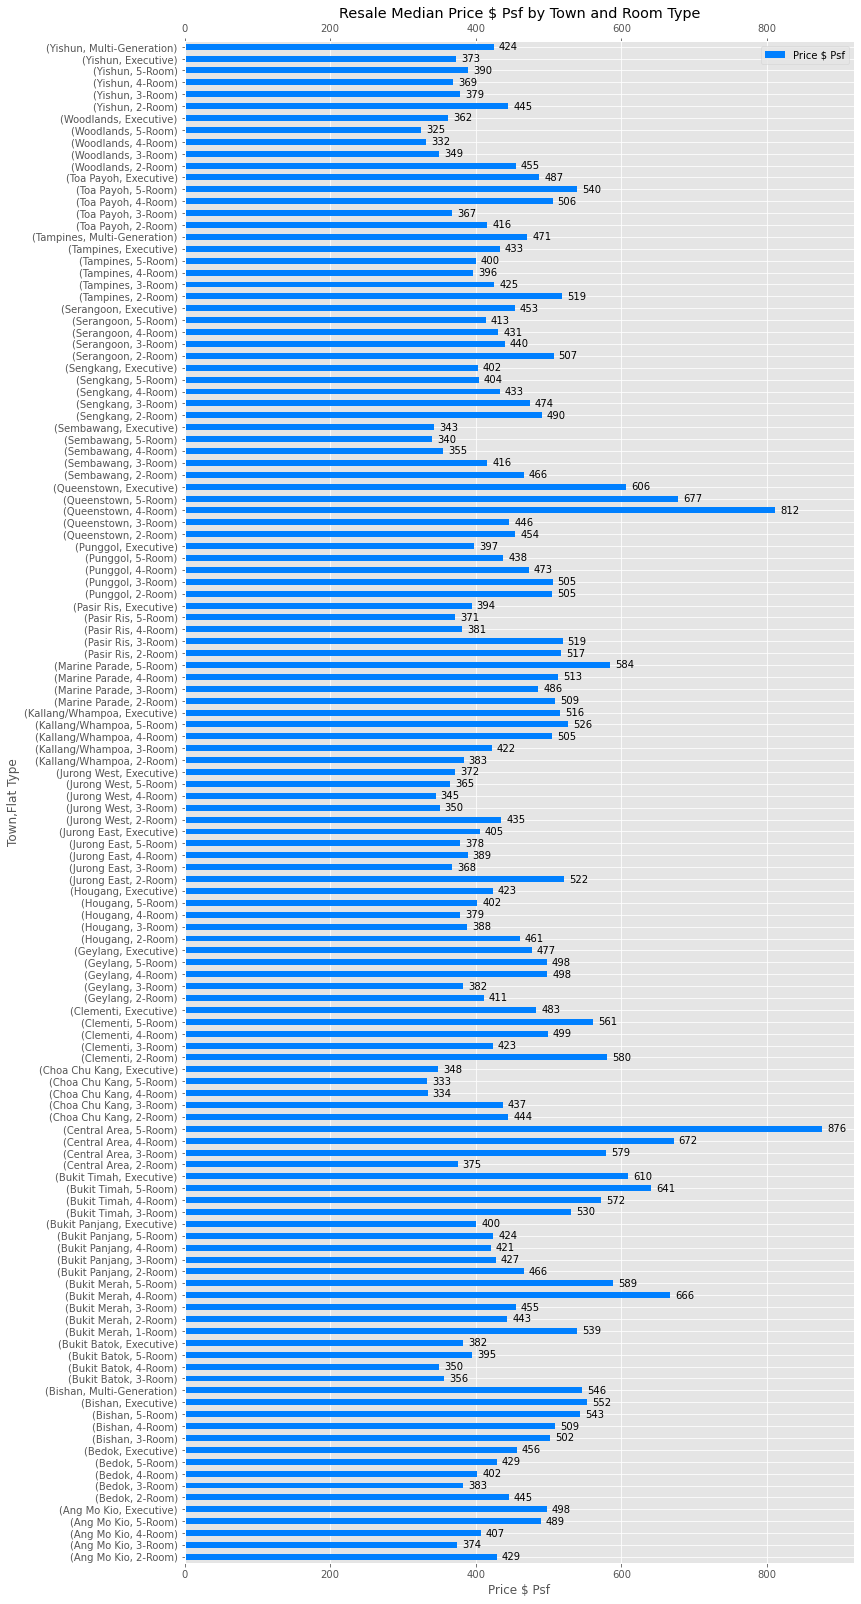

In [19]:
hdb_median_prices = hdb.groupby(['Town','Flat Type']).agg({'Price per Sqft':'median'})
ax = hdb_median_prices.plot(kind = 'barh', figsize=(12,28), color='#0080FF')
# plt.suptitle(f"Median Price psf by Town", fontsize=18)
ax.set_xlabel("Price $ Psf", fontsize=12)
ax.set_title(f'Resale Median Price $ Psf by Town and Room Type')
ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if width > 0 and width < np.inf:
        ax.annotate(int(round(width)),\
                    (x+width+20, y),\
                    ha='center', va='center', xytext=(0, 3), textcoords='offset points')

ax.legend(['Price $ Psf'])
plt.show()

## Price (Median) per Sqft by Town and Room Type per Remaining Lease Year

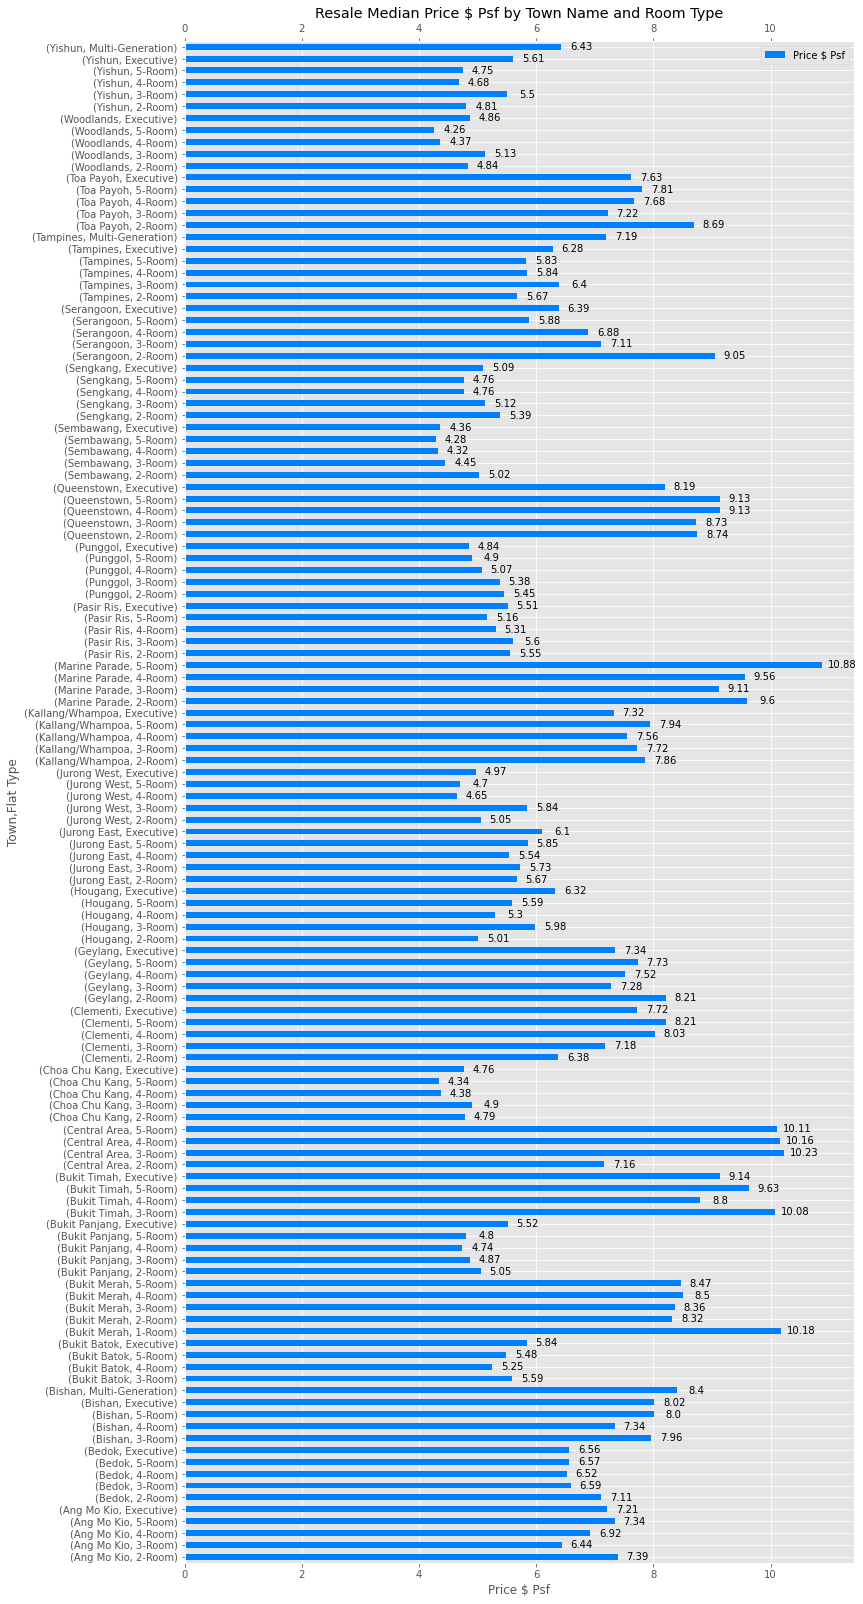

In [20]:
hdb_median_prices_remaining_lease = hdb.groupby(['Town','Flat Type']).agg({'Price per Sqft per Remaining Lease year':'median'})
ax = hdb_median_prices_remaining_lease.plot(kind = 'barh', figsize=(12,28), color='#0080FF')
# plt.suptitle(f"Median Price psf by Town", fontsize=18)
ax.set_xlabel("Price $ Psf", fontsize=12)
ax.set_title(f'Resale Median Price $ Psf by Town Name and Room Type')
ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)
ax.legend(['Price $ Psf'])
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if width > 0 and width < np.inf:
        ax.annotate(round(width,2),\
                    (x+width, y),\
                    ha='center', va='center', xytext=(20, 3), textcoords='offset points')

plt.show()

## Remaining Lease Year by Town

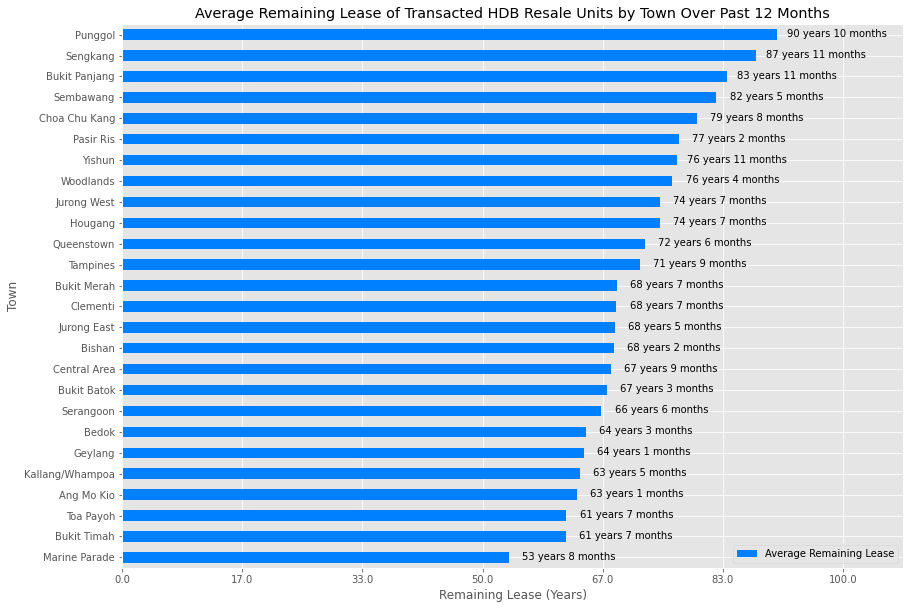

In [21]:
remaining_lease = hdb.groupby('Town').agg({'Remaining Lease in Months':'mean'}).reset_index()
remaining_lease['Remaining Lease in Years'] = remaining_lease['Remaining Lease in Months']//12
remaining_lease['Remaining Lease in (Months)'] = round(remaining_lease['Remaining Lease in Months']%12)
remaining_lease['Remaining Lease'] = remaining_lease['Remaining Lease in Years'].\
astype(int).astype(str) + ' years ' + remaining_lease['Remaining Lease in (Months)'].astype(int).astype(str) + ' months'
remaining_lease = remaining_lease.sort_values(by = 'Remaining Lease in Months')
ax = remaining_lease.plot(kind = 'barh', figsize=(14,10), color='#0080FF', x='Town', y='Remaining Lease in Months')
ax.set_xticklabels(np.round(np.arange(0,101,100/6)))
ax.legend(['Average Remaining Lease'])
ax.set_xlabel('Remaining Lease (Years)')
ax.set_xlim(0,1300)
cnt = 0
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if width > 0 and width < np.inf:
        ax.annotate(remaining_lease['Remaining Lease'].iloc[cnt],\
                    (x+width+100, y+height-0.7),\
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    cnt+=1

ax.set_title(f'Average Remaining Lease of Transacted HDB Resale Units by Town Over Past {n_months} Months')

plt.show()

## Psft of HDBs with Lease < 60 years by Town and Room Type

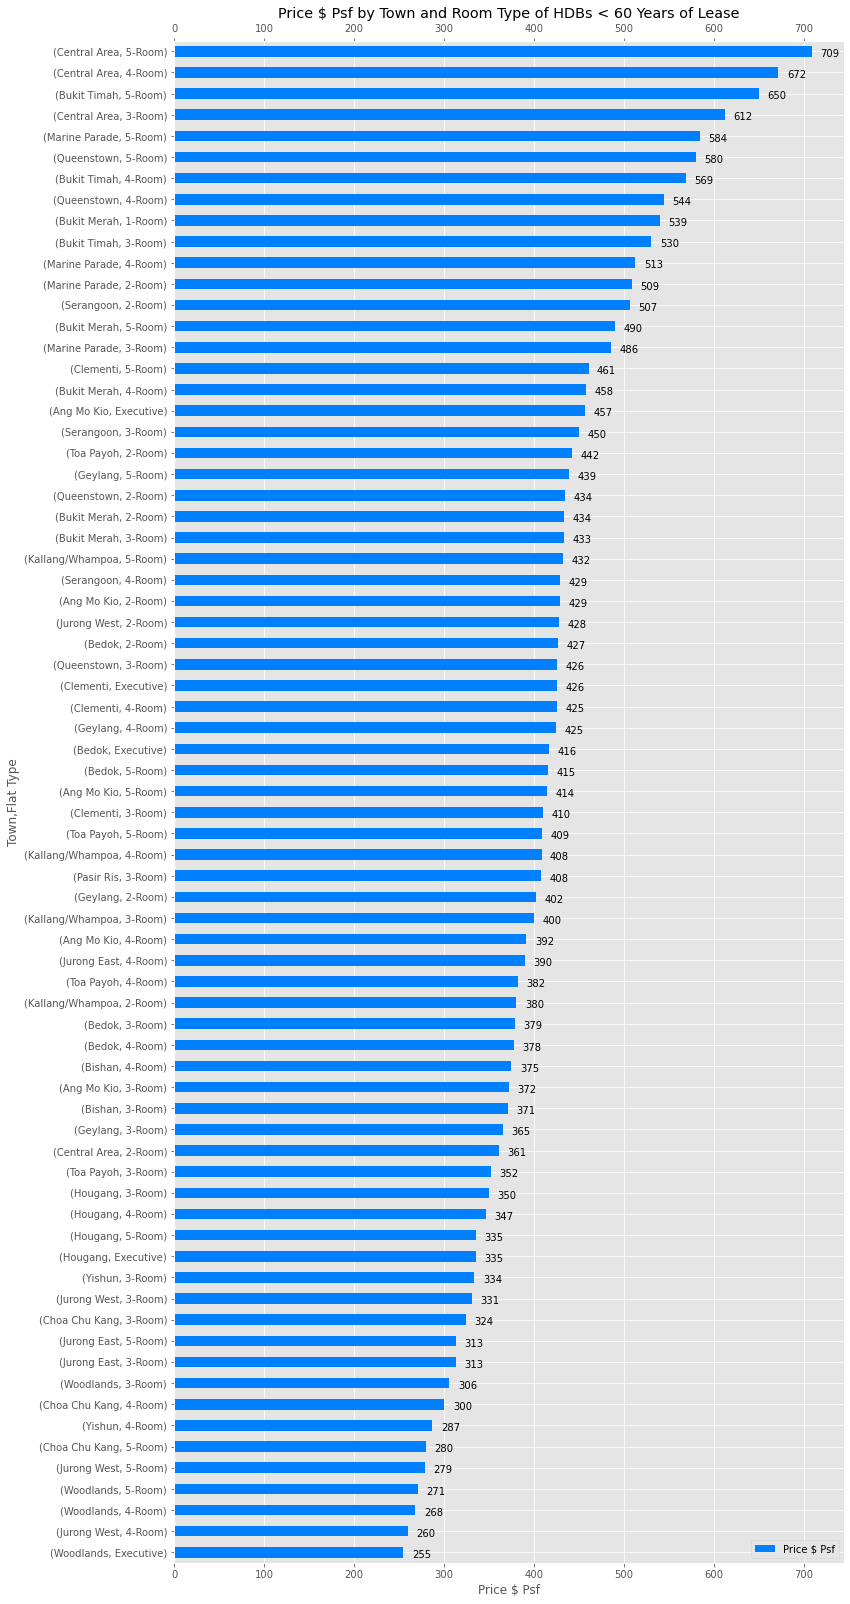

In [22]:
n=60
hdb_median_prices = hdb[hdb['Remaining Lease (Year)']<n].groupby(['Town','Flat Type']).agg({'Price per Sqft':'median'}).\
sort_values(by='Price per Sqft')
ax = hdb_median_prices.plot(kind = 'barh', figsize=(12,28), color='#0080FF')
# plt.suptitle(f"Median Price psf by Town", fontsize=18)
ax.set_xlabel("Price $ Psf", fontsize=12)
ax.set_title(f'Price $ Psf by Town and Room Type of HDBs < {n} Years of Lease')
ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if width > 0 and width < np.inf:
        ax.annotate(int(round(width)),\
                    (x+width+20, y),\
                    ha='center', va='center', xytext=(0, 3), textcoords='offset points')

ax.legend(['Price $ Psf'])
plt.show()

## Check Similar Resale HDBs by filtering base on psft per remaining lease year and max price

In [23]:
v = 8.5 # psft per remaining lease year
p = 800000 # max price

In [24]:
result = hdb[(hdb['Price per Sqft per Remaining Lease year']>=v-0.5)&\
            ~(hdb['Flat Type'].isin(['1-Room','2-Room','3-Room']))&(hdb.Sqm>100)&(hdb.Price<p)]
print(result.shape)
result.sort_values(by=['Town','Flat Type','Price per Sqft per Remaining Lease year'])

(399, 28)


,Town Code,Town,Block,Street,Storey,Floor Area/Flat Model,Floor Area,Flat Model,Flat Type,Lease Commencement Date,Remaining Lease,Price,Resale Registration Date,Resale Registration Month,Resale Registration Year,Remaining Lease (Year),Remaining Lease (Month),Remaining Lease in Months,Sqm,Sqft,Price per Sqm,Price per Sqft,Price per Sqft per Remaining Lease year,Storey Range + Flat Type,Price rank room type,Price rank room type (descending),Price per Sqft Rank,Price per Sqft Rank (Descending)
941,AMK,Ang Mo Kio,316A,Ang Mo Kio St 31,25 to 27,110.00Improved,110.0,Improved,5-Room,2006,84 years 7 months,798000.0,Sep 2020,Sep,2020,84,0,1008,110.0,1184.040,7254.545455,673.963717,8.023378,25 to 27 5-Room,450.0,5872.0,450.0,5872.0
863,AMK,Ang Mo Kio,305,Ang Mo Kio Ave 1,13 to 15,123.00Standard,123.0,Standard,5-Room,1977,55 years 7 months,590000.0,Jan 2021,Jan,2021,55,0,660,123.0,1323.972,4796.747967,445.628760,8.102341,13 to 15 5-Room,1694.0,4628.0,1694.0,4628.0
874,AMK,Ang Mo Kio,102,Ang Mo Kio Ave 3,10 to 12,127.00Improved,127.0,Improved,5-Room,1993,71 years 5 months,790000.0,Dec 2020,Dec,2020,71,0,852,127.0,1367.028,6220.472441,577.895990,8.139380,10 to 12 5-Room,462.5,5859.5,462.5,5859.5
949,AMK,Ang Mo Kio,311,Ang Mo Kio Ave 3,13 to 15,123.00Improved,123.0,Improved,5-Room,1978,56 years 5 months,605000.0,Aug 2020,Aug,2020,56,0,672,123.0,1323.972,4918.699187,456.958304,8.159970,13 to 15 5-Room,1557.0,4765.0,1557.0,4765.0
978,AMK,Ang Mo Kio,351,Ang Mo Kio St 32,25 to 27,110.00Improved,110.0,Improved,5-Room,2001,80 years 5 months,778000.0,Jun 2020,Jun,2020,80,0,960,110.0,1184.040,7072.727273,657.072396,8.213405,25 to 27 5-Room,506.5,5815.5,506.5,5815.5
1033,AMK,Ang Mo Kio,596A,Ang Mo Kio St 52,28 to 30,110.00Improved,110.0,Improved,5-Room,2002,81 years 11 months,789000.0,Jan 2020,Jan,2020,81,0,972,110.0,1184.040,7172.727273,666.362623,8.226699,28 to 30 5-Room,469.0,5853.0,469.0,5853.0
962,AMK,Ang Mo Kio,725,Ang Mo Kio Ave 6,10 to 12,119.00Improved,119.0,Improved,5-Room,1980,58 years 11 months,615000.0,Jul 2020,Jul,2020,58,0,696,119.0,1280.916,5168.067227,480.125160,8.278020,10 to 12 5-Room,1461.0,4861.0,1461.0,4861.0
929,AMK,Ang Mo Kio,596D,Ang Mo Kio St 52,22 to 24,110.00Improved,110.0,Improved,5-Room,2003,81 years 4 months,798000.0,Oct 2020,Oct,2020,81,0,972,110.0,1184.040,7254.545455,673.963717,8.320540,22 to 24 5-Room,450.0,5872.0,450.0,5872.0
892,AMK,Ang Mo Kio,552,Ang Mo Kio Ave 10,25 to 27,119.00Improved,119.0,Improved,5-Room,1980,58 years 10 months,623000.0,Nov 2020,Nov,2020,58,0,696,119.0,1280.916,5235.294118,486.370691,8.385702,25 to 27 5-Room,1392.0,4930.0,1392.0,4930.0
878,AMK,Ang Mo Kio,521,Ang Mo Kio Ave 5,04 to 06,118.00Improved,118.0,Improved,5-Room,1980,58 years 8 months,618000.0,Dec 2020,Dec,2020,58,0,696,118.0,1270.152,5237.288136,486.555940,8.388896,04 to 06 5-Room,1436.0,4886.0,1436.0,4886.0


## Analyze HDB Resale Prices of a specific Town

In [25]:
mytown = 'Clementi'
twn = hdb[hdb['Town'] == mytown]

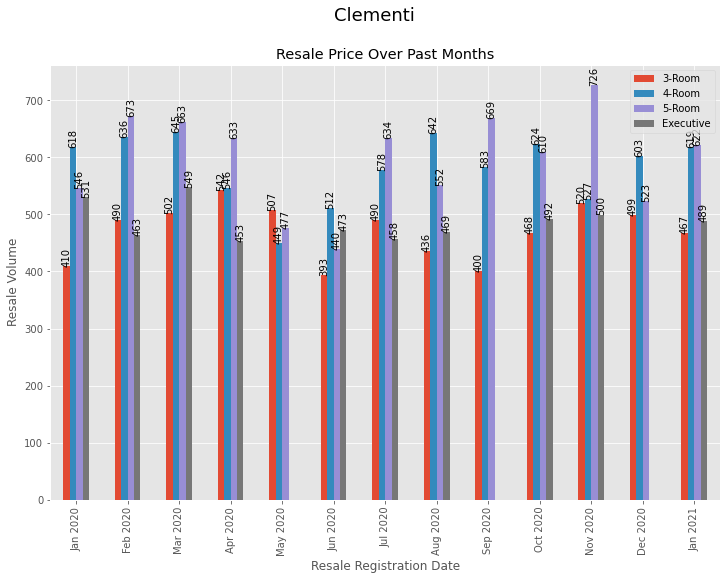

In [26]:
twn_px = twn[twn['Flat Type'].isin(['3-Room','4-Room','5-Room','Executive'])].\
groupby(['Resale Registration Date','Flat Type']).agg({'Price per Sqft':'mean'}).unstack('Flat Type').fillna(0).reset_index()
twn_px.columns = ['Resale Registration Date','3-Room','4-Room','5-Room','Executive']
twn_px['Resale Registration Date'] =  pd.to_datetime(twn_px['Resale Registration Date'], format='%b %Y')
twn_px = twn_px.sort_values(by=['Resale Registration Date'], ascending=True)
twn_px['Resale Registration Date'] = twn_px['Resale Registration Date'].apply(lambda x: datetime.strftime(x, '%b %Y'))
twn_px.set_index(['Resale Registration Date'], inplace=True)

ax = twn_px.plot(kind='bar', stacked=False, figsize=(12,8), title=f'Resale Price Over Past Months')
ax.legend(bbox_to_anchor=(1, 1))
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0 and height < np.inf:
        ax.annotate(int(round(height)),\
                    (x+width/2, y+height+10),\
                    ha='center', va='center', xytext=(0, 3), textcoords='offset points', rotation = 90)
plt.suptitle(f"{mytown}", fontsize=18)
ax.set_ylabel('Resale Volume')
plt.show()

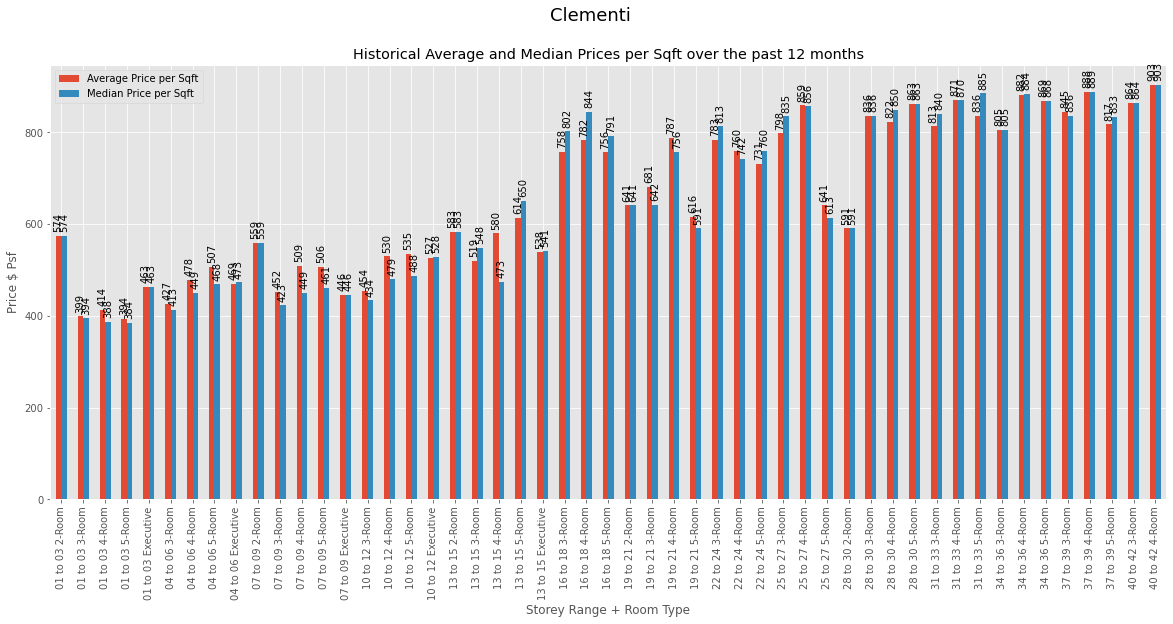

In [27]:
toplot = twn.groupby(['Town','Storey','Flat Type']).\
agg({'Town':'count', 'Price':['mean','median'], 'Price per Sqm':['mean','median'],\
                                                       'Price per Sqft':['mean','median']}).reset_index()
toplot.columns = ['Town','Storey','Flat Type','Total Units','Average Price','Median Price',\
                  'Average Price per Sqm','Median Price per Sqm',\
                  'Average Price per Sqft','Median Price per Sqft']
toplot = toplot.round({'Average Price':2,'Median Price':2,\
                  'Average Price per Sqm':2,'Median Price per Sqm':2,\
                  'Average Price per Sqft':2,'Median Price per Sqft':2})
toplot['Storey Range + Room Type'] = toplot['Storey'] + ' ' + toplot['Flat Type']

# toplot

ax = toplot.plot(kind='bar', figsize=(20,8), x = 'Storey Range + Room Type',\
                 y=['Average Price per Sqft','Median Price per Sqft'])

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0 and height < np.inf:
        ax.annotate(int(round(height)),\
                    (x+width/2, y+height+10),\
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points', rotation = 90)

plt.suptitle(f"{mytown}", fontsize=18)
ax.set_ylabel("Price $ Psf", fontsize=12)
ax.set_title(f'Historical Average and Median Prices per Sqft over the past 12 months')
plt.show()



## Analyze HDB Resale Prices of a specific Street

In [28]:
hdb[hdb['Town'] == mytown].Street.unique()

array(['Clementi St 13', 'Clementi Ave 1', 'Clementi Ave 2',
       'Clementi Ave 4', 'Clementi Ave 5', 'Clementi West St 2',
       'Clementi Ave 3', "C'wealth Ave West", 'Clementi Ave 6',
       'West Coast Dr', 'Clementi West St 1', 'West Coast Rd',
       'Clementi St 12', 'Clementi St 14', 'Clementi St 11'], dtype=object)

#### Street check 1

In [29]:
mystreet = "Clementi Ave 4"
town_street = hdb[hdb['Street'].isin([mystreet])]

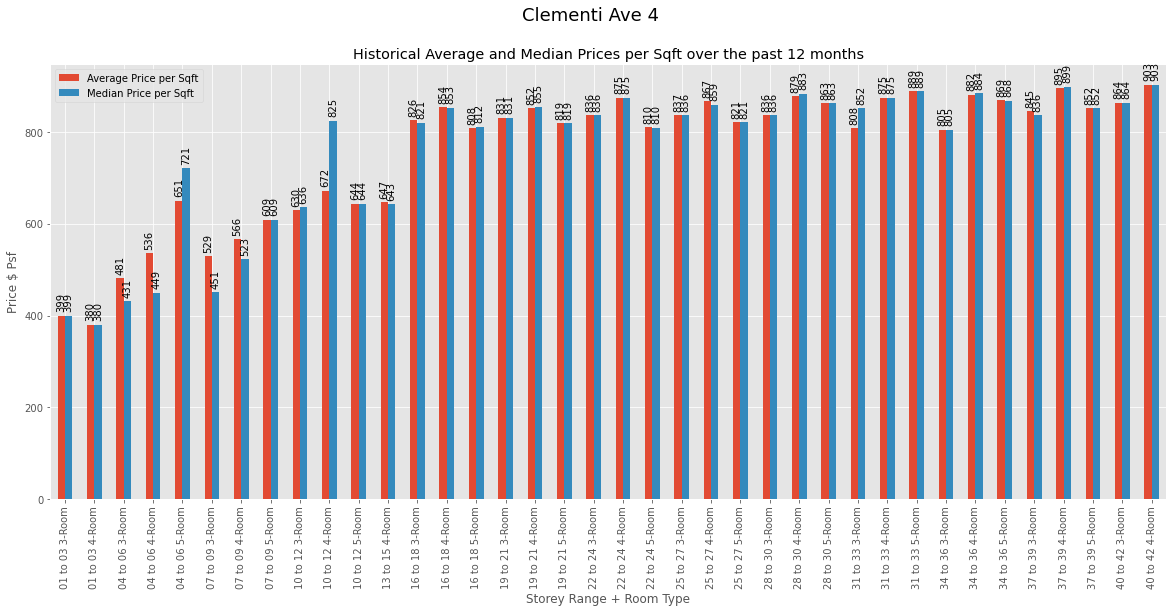

In [30]:
toplot = town_street.groupby(['Town','Storey','Flat Type']).\
agg({'Town':'count', 'Price':['mean','median'], 'Price per Sqm':['mean','median'],\
                                                       'Price per Sqft':['mean','median']}).reset_index()
toplot.columns = ['Town','Storey','Flat Type','Total Units','Average Price','Median Price',\
                  'Average Price per Sqm','Median Price per Sqm',\
                  'Average Price per Sqft','Median Price per Sqft']
toplot = toplot.round({'Average Price':2,'Median Price':2,\
                  'Average Price per Sqm':2,'Median Price per Sqm':2,\
                  'Average Price per Sqft':2,'Median Price per Sqft':2})
toplot['Storey Range + Room Type'] = toplot['Storey'] + ' ' + toplot['Flat Type']

# toplot

ax = toplot.plot(kind='bar', figsize=(20,8), x = 'Storey Range + Room Type', y=['Average Price per Sqft','Median Price per Sqft'])

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0 and height < np.inf:
        ax.annotate(int(round(height)),\
                    (x+width/2, y+height+10),\
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points', rotation = 90)

plt.suptitle(f"{mystreet}", fontsize=18)
ax.set_ylabel("Price $ Psf", fontsize=12)
ax.set_title(f'Historical Average and Median Prices per Sqft over the past 12 months')
plt.show()

#### Street check 2

In [31]:
mystreet = 'Tampines Ctrl 8'
tamp = hdb[hdb['Street'].isin([mystreet])]

In [32]:
toplot = tamp.groupby(['Town','Storey','Flat Type']).\
agg({'Town':'count', 'Price':['mean','median'], 'Price per Sqm':['mean','median'],\
                                                       'Price per Sqft':['mean','median']}).reset_index()
toplot.columns = ['Town','Storey','Flat Type','Total Units','Average Price','Median Price',\
                  'Average Price per Sqm','Median Price per Sqm',\
                  'Average Price per Sqft','Median Price per Sqft']
toplot = toplot.round({'Average Price':2,'Median Price':2,\
                  'Average Price per Sqm':2,'Median Price per Sqm':2,\
                  'Average Price per Sqft':2,'Median Price per Sqft':2})
toplot['Storey Range + Room Type'] = toplot['Storey'] + ' ' + toplot['Flat Type']

toplot

,Town,Storey,Flat Type,Total Units,Average Price,Median Price,Average Price per Sqm,Median Price per Sqm,Average Price per Sqft,Median Price per Sqft,Storey Range + Room Type
0,Tampines,01 to 03,3-Room,1,445000.00,445000.0,7177.42,7177.42,666.80,666.80,01 to 03 3-Room
1,Tampines,01 to 03,4-Room,2,602500.00,602500.0,7172.62,7172.62,666.35,666.35,01 to 03 4-Room
2,Tampines,04 to 06,3-Room,6,471814.67,472944.0,7609.91,7628.13,706.98,708.67,04 to 06 3-Room
3,Tampines,04 to 06,4-Room,6,624333.33,628000.0,7447.60,7476.19,691.90,694.56,04 to 06 4-Room
4,Tampines,04 to 06,5-Room,2,800000.00,800000.0,7407.41,7407.41,688.16,688.16,04 to 06 5-Room
5,Tampines,07 to 09,3-Room,4,480000.00,480000.0,7838.45,7868.85,728.21,731.03,07 to 09 3-Room
6,Tampines,07 to 09,4-Room,7,639555.43,642000.0,7653.06,7642.86,710.99,710.04,07 to 09 4-Room
7,Tampines,10 to 12,3-Room,4,499222.00,501944.0,8085.35,8095.87,751.15,752.12,10 to 12 3-Room
8,Tampines,10 to 12,4-Room,8,655361.00,659000.0,7837.42,7845.24,728.11,728.84,10 to 12 4-Room
9,Tampines,10 to 12,5-Room,1,808888.00,808888.0,7489.70,7489.70,695.81,695.81,10 to 12 5-Room


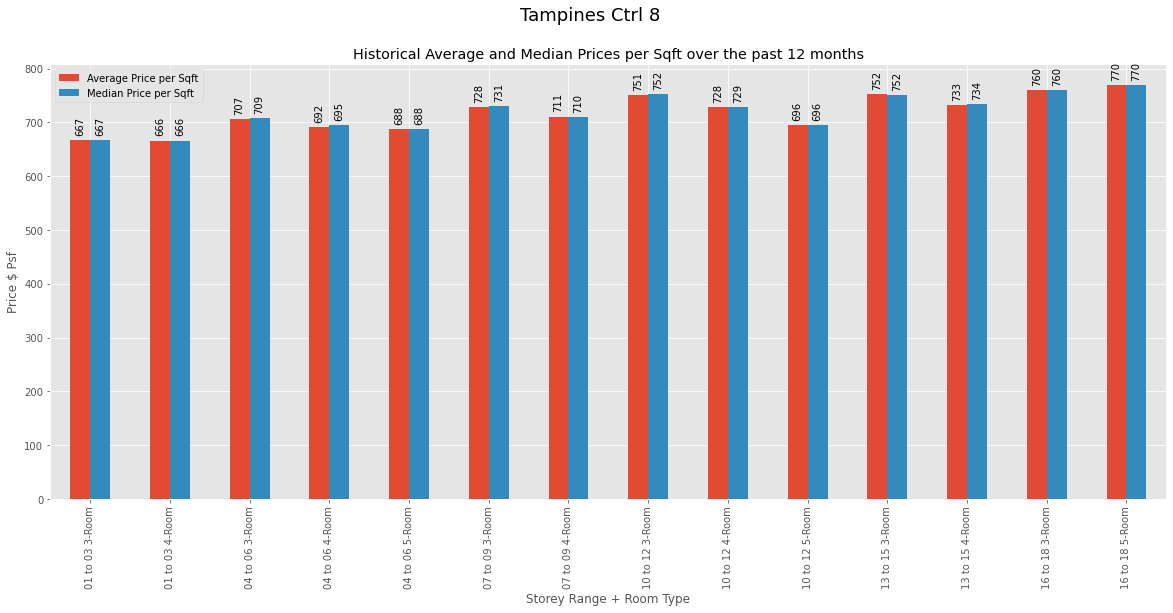

In [33]:
ax = toplot.plot(kind='bar', figsize=(20,8), x = 'Storey Range + Room Type', y=['Average Price per Sqft','Median Price per Sqft'])

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0 and height < np.inf:
        ax.annotate(int(round(height)),\
                    (x+width/2, y+height+10),\
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points', rotation = 90)

plt.suptitle(f"{mystreet}", fontsize=18)
ax.set_ylabel("Price $ Psf", fontsize=12)
ax.set_title(f'Historical Average and Median Prices per Sqft over the past 12 months')
plt.show()

<a id='DBSS'>DBSS</a>

In [34]:
hdb['Flat Model'].unique()

array(['Model', 'Premium', 'Improved', 'Standard', 'New', 'Maisonette',
       'Simplified', 'Dbss', 'Apartment', 'Adjoined', 'Type', 'Multi',
       'Terrace', 'Room'], dtype=object)

In [35]:
dbss = hdb[hdb['Flat Model']=='Dbss']

In [36]:
toplot = dbss.groupby(['Town','Flat Type']).\
agg({'Town':'count', 'Price':['mean','median'], 'Price per Sqm':['mean','median'],\
                                                       'Price per Sqft':['mean','median']}).reset_index()
toplot.columns = ['Town','Flat Type','Total Units','Average Price','Median Price',\
                  'Average Price per Sqm','Median Price per Sqm',\
                  'Average Price per Sqft','Median Price per Sqft']
toplot = toplot.round({'Average Price':2,'Median Price':2,\
                  'Average Price per Sqm':2,'Median Price per Sqm':2,\
                  'Average Price per Sqft':2,'Median Price per Sqft':2})
toplot['Town + Room Type'] = toplot['Town'] + ' ' + toplot['Flat Type']

toplot

,Town,Flat Type,Total Units,Average Price,Median Price,Average Price per Sqm,Median Price per Sqm,Average Price per Sqft,Median Price per Sqft,Town + Room Type
0,Ang Mo Kio,4-Room,13,726222.15,732000.0,8034.85,8111.11,746.46,753.54,Ang Mo Kio 4-Room
1,Ang Mo Kio,5-Room,24,852065.67,845444.0,7497.81,7437.08,696.56,690.92,Ang Mo Kio 5-Room
2,Bedok,3-Room,14,489634.86,491500.0,7387.05,7415.82,686.27,688.95,Bedok 3-Room
3,Bedok,4-Room,31,668516.13,665000.0,7698.20,7643.68,715.18,710.12,Bedok 4-Room
4,Bedok,5-Room,22,804863.64,798000.0,7625.00,7561.90,708.38,702.52,Bedok 5-Room
5,Bishan,4-Room,10,839288.80,859000.0,8834.62,9042.11,820.76,840.03,Bishan 4-Room
6,Bishan,5-Room,18,1025771.56,1055000.0,8548.10,8791.67,794.14,816.77,Bishan 5-Room
7,Clementi,3-Room,30,524729.60,530000.0,8745.49,8833.33,812.48,820.64,Clementi 3-Room
8,Clementi,4-Room,56,751961.68,752500.0,9298.00,9308.69,863.81,864.80,Clementi 4-Room
9,Clementi,5-Room,21,928720.95,928400.0,8844.96,8841.90,821.72,821.43,Clementi 5-Room


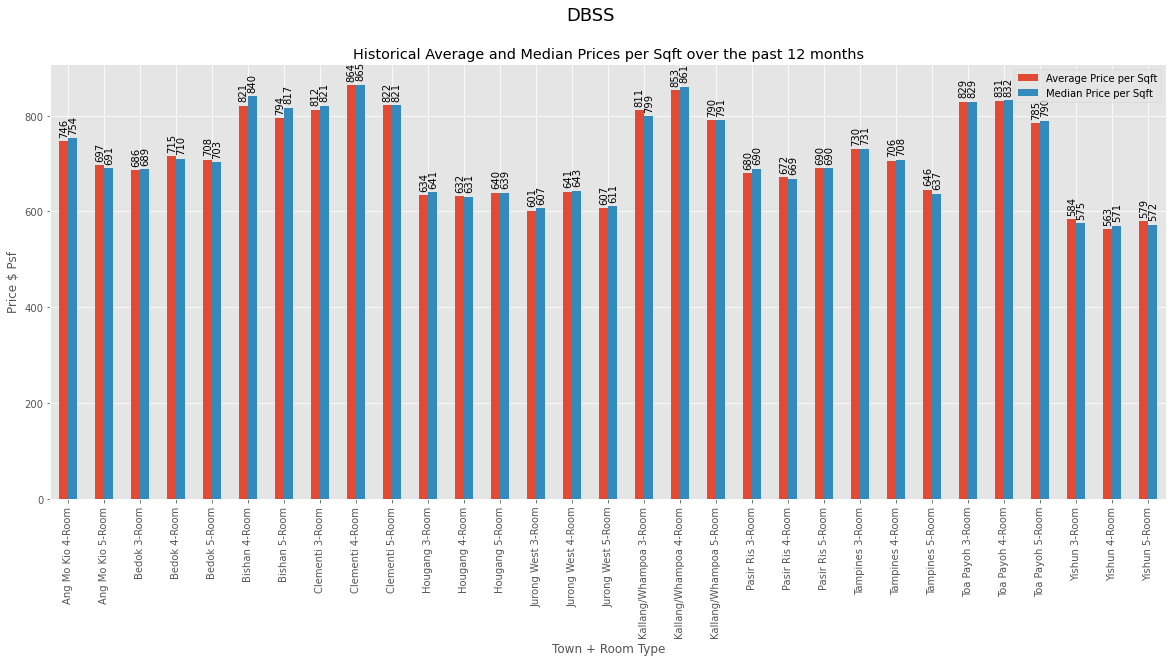

In [37]:
ax = toplot.plot(kind='bar', figsize=(20,8), x = 'Town + Room Type', y=['Average Price per Sqft','Median Price per Sqft'])

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0 and height < np.inf:
        ax.annotate(int(round(height)),\
                    (x+width/2, y+height+10),\
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points', rotation = 90)

plt.suptitle(f"DBSS", fontsize=18)
ax.set_ylabel("Price $ Psf", fontsize=12)
ax.set_title(f'Historical Average and Median Prices per Sqft over the past 12 months')
plt.show()